==================================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk / viluiz@gmail.com
==================================================================

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Common imports
import numpy as np
import os
import time
from collections import deque
import joblib
import shutil
import subprocess
import glob

# Python path for running in parallel (conda env py3ml)
pythonpath = '/home/viluiz/anaconda3/envs/py3ml/bin/python'
assert os.path.exists(pythonpath)

# Load and prepare data

In [2]:
# -----------------------------------------
# Load data and GAN model
# -----------------------------------------

# Mesh size
nl = 10
nc = 10

#Load PCA and Scaler
pca_compress = joblib.load("pca_compress_15.pkl") 
scaler = joblib.load("scaler.pkl")

# Train data
X_train_compressed = np.loadtxt('X_train_pca.csv', delimiter=',') 
X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('times.csv', delimiter=',') 
R0s_train  = np.loadtxt('R0s.csv', delimiter=',') 
with open('groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# Test data
X_test_compressed = np.loadtxt('X_test_pca.csv', delimiter=',') 
X_test_1D = np.loadtxt('X_test_1D.csv', delimiter=',') 
R0s_test  = np.loadtxt('R0s_test.csv', delimiter=',') 

# Test uq data
X_testuq_compressed = np.loadtxt('X_testuq_pca.csv', delimiter=',') 
X_testuq_1D = np.loadtxt('X_testuq_1D.csv', delimiter=',') 
R0s_testuq  = np.loadtxt('R0s_testuq.csv', delimiter=',') 

# GAN model
#generator, discriminator = load_model('gan-tfex-DCGAN-5kernel.h5').layers
#latent_size = 100 # size of the latent space (input of the generator)

(38520, 10, 17)
(38520, 10, 17)
(192600, 10, 17)


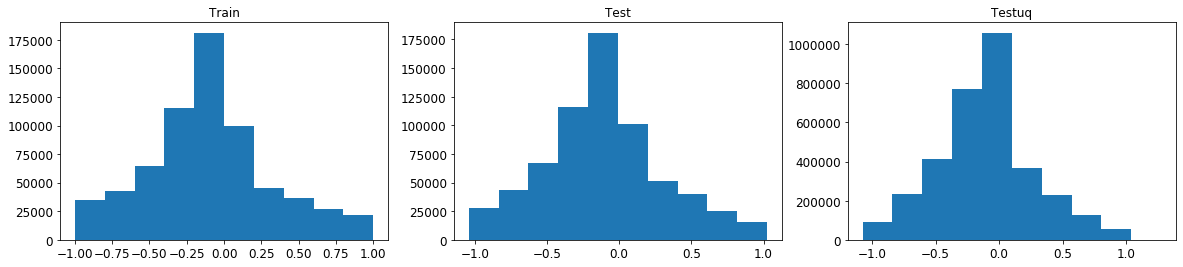

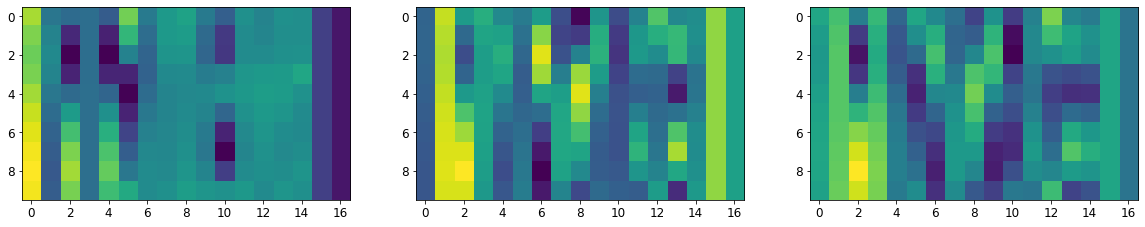

In [3]:
# -----------------------------------------
# Prepare data
# -----------------------------------------

pca_size = X_test_compressed.shape[1] # number of POD coeffients

X_train_R0s = R0s_train.repeat(len(times), axis=0) 
X_test_R0s = R0s_test.repeat(len(times), axis=0)
X_testuq_R0s = R0s_testuq.repeat(len(times), axis=0)

X_train_compressedplus = np.concatenate((X_train_compressed, X_train_R0s), axis=1) 
X_test_compressedplus = np.concatenate((X_test_compressed, X_test_R0s), axis=1) 
X_testuq_compressedplus = np.concatenate((X_testuq_compressed, X_testuq_R0s), axis=1) 
codings_size = X_test_compressedplus.shape[1] # number of POD coeffients + the number of model parameters

X_train_scaled = scaler.transform(X_train_compressedplus)
X_test_scaled = scaler.transform(X_test_compressedplus)
X_testuq_scaled = scaler.transform(X_testuq_compressedplus)

fig, ax = plt.subplots(1,3, figsize=[20,4])
ax[0].hist(X_train_scaled.flatten())
ax[0].set_title('Train')
ax[1].hist(X_test_scaled.flatten())
ax[1].set_title('Test')
ax[2].hist(X_testuq_scaled.flatten())
ax[2].set_title('Testuq')

# Concatenate successive time steps  
def concat_timesteps(X_train, ntimes, step, times):
    X_train_concat = []
    for j in range(len(X_train)//len(times)):
        for i in range(j*len(times), j*len(times)+(len(times)-ntimes*step)):
            X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 10 # Consecutive times for the GAN
step = 2 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step, times)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

X_test_concat = concat_timesteps(X_test_scaled, ntimes, step, times)
X_test_concat_flatten = X_test_concat.reshape(X_test_concat.shape[0], codings_size*ntimes )

X_testuq_concat = concat_timesteps(X_testuq_scaled, ntimes, step, times)
X_testuq_concat_flatten = X_testuq_concat.reshape(X_testuq_concat.shape[0], codings_size*ntimes )

fig, ax1 = plt.subplots(1,3, figsize=[20,4])
print(X_train_concat.shape)
ax1[0].imshow(X_train_concat[10000, :, :])
print(X_test_concat.shape)
ax1[1].imshow(X_test_concat[10000, :, :])
print(X_testuq_concat.shape)
ax1[2].imshow(X_testuq_concat[10000, :, :])
plt.show()

Text(0.5, 1.0, 'R0 Mobile')

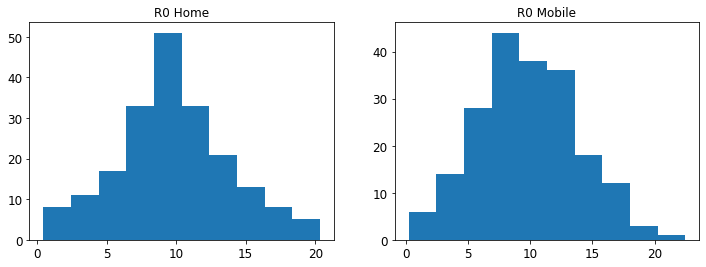

In [4]:
fig, ax = plt.subplots(1,2, figsize=[12,4])
ax[0].hist(R0s_testuq[:,0])
ax[0].set_title('R0 Home')
ax[1].hist(R0s_testuq[:,1])
ax[1].set_title('R0 Mobile')

## Generate observed 

X_obs.shape (259, 8, 10, 10)
R0s_obs [ 7.72820859 17.37615382]
obs_points.shape:  (140, 4)


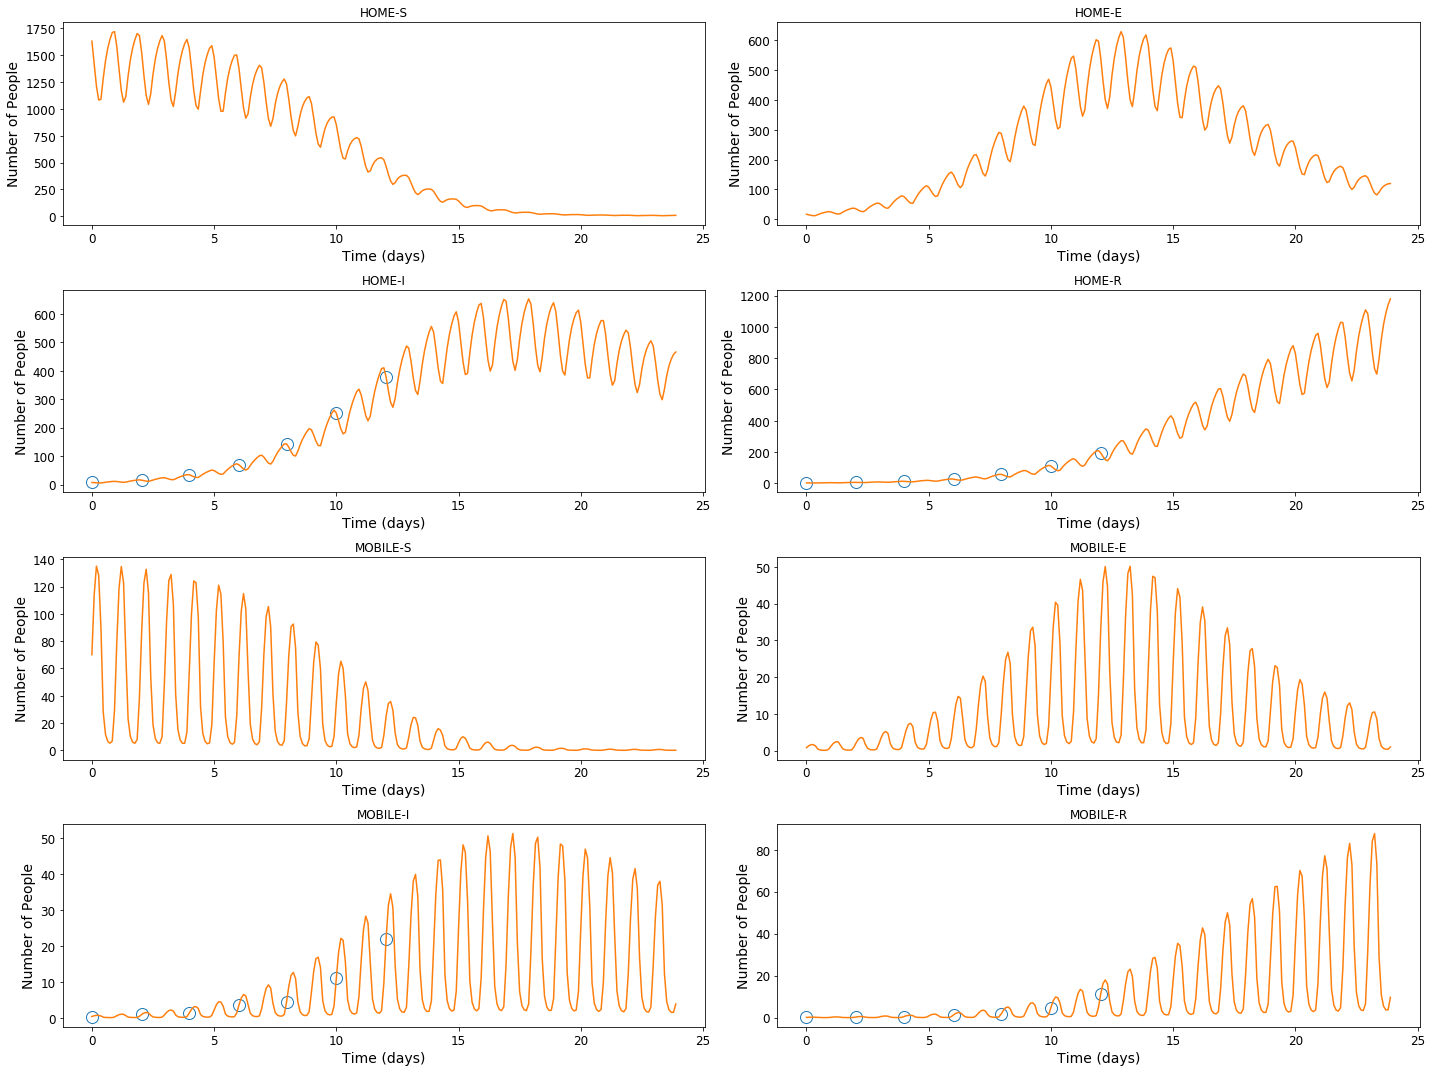

In [5]:
# -----------------------------------------
# Generate observed data
# -----------------------------------------

run_obs = 2 # from the test dataset
lag = 173 # starting point (in time steps)
length = 250 # length + (ntimes-1) -> len of X_obs (in forward steps = 2 time steps) 
seed = 0
noise = 0.00

# Times of X_obs to be considered for data assimilation
obs_times = list(map(int,map(round,np.arange(0,length+(ntimes-1)-120,21.6))))


# grid points: used to populate the obs_points
#[[group, line, column], 
# [group, line, column], 
# ...                 ]
grid_points = [[2,0,4],[6,0,4],[3,0,4],[7,0,4],
               [2,9,4],[6,9,4],[3,9,4],[7,9,4],
               [2,4,4],[6,4,4],[3,4,4],[7,4,4],
               [2,4,0],[6,4,0],[3,4,0],[7,4,0],
               [2,4,9],[6,4,9],[3,4,9],[7,4,9],
               #[0,0,4],[1,0,4],[2,0,4],[3,0,4],[4,0,4],[5,0,4],[6,0,4],[7,0,4],
               #[0,9,4],[1,9,4],[2,9,4],[3,9,4],[4,9,4],[5,9,4],[6,9,4],[7,9,4],
               #[0,4,4],[1,4,4],[2,4,4],[3,4,4],[4,4,4],[5,4,4],[6,4,4],[7,4,4],
               #[0,4,0],[1,4,0],[2,4,0],[3,4,0],[4,4,0],[5,4,0],[6,4,0],[7,4,0],
               #[0,4,9],[1,4,9],[2,4,9],[3,4,9],[4,4,9],[5,4,9],[6,4,9],[7,4,9],
               ]

def obs_data(run_obs, lag, length, seed, noise, obs_times, grid_points, verbose=0):

    nobs = len(times)*run_obs + lag

    # Get the observed data
    X_obs = X_test_1D[nobs:nobs+((ntimes-1)+length)*step:step,:].reshape(-1,len(groups),nl,nc)
    R0s_obs = R0s_test[run_obs]

    # Add noise
    np.random.seed(seed)
    X_obs = X_obs + np.random.standard_normal(X_obs.shape)*noise*X_obs

    # Print values
    if verbose>0: 
        print('X_obs.shape', X_obs.shape)
        print('R0s_obs', R0s_obs)

    # obs_points:
    #[[time, group, line, column], 
    # [time, group, line, column], 
    # ...                       ]
    obs_points = []
    for p in grid_points:
        for t in obs_times:
            obs_points.append([t]+p)
    obs_points = np.array(obs_points)
    if verbose>0:
        print('obs_points.shape: ', obs_points.shape)
    
    return X_obs, R0s_obs, obs_points

X_obs, R0s_obs, obs_points = obs_data(run_obs, lag, length, seed, noise, obs_times, grid_points, verbose=1)

fig, X_ax = plt.subplots(4,2, figsize=[20,15])
for i, group in enumerate(groups):
    if [i, 0, 4] in grid_points:
        X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, X_obs[obs_times][:, i, 0, 4], 'o', markevery=1, fillstyle='none', markersize = 12, label='Observed data')
    else:
        X_ax.flatten()[i].plot([],[])
    X_ax.flatten()[i].plot(np.array(range(len(X_obs)))*8000/86400, X_obs[:][:, i, 0, 4], '-', markevery=1, fillstyle='none', markersize = 12, label='Observed data')        
    X_ax.flatten()[i].set_title(group)
    X_ax.flatten()[i].set_xlabel('Time (days)')
    X_ax.flatten()[i].set_ylabel('Number of People')
plt.tight_layout()
plt.show()

# Run uncertainty quantification

In [6]:
nparalel = 40
processes = []
dirnames = []
logfile = []

n_testuq = int(len(X_testuq_concat)/(len(times)- ntimes*step))

pyfile = 'da-predgan.py'
rundir = 'runuq_1/'
if os.path.exists(rundir):
    print('\n*** WARNING: Directory already exists: ./' + rundir)
    print('\n*** WARNING: All data assimilations will be considered finished!')
    print('\nContinuing execution!')
else:
    os.mkdir(rundir)

    j = 0
    for i in range(n_testuq):

        # Create folder and copy files
        dirnames.append( rundir+'testuq'+str(i)+'seed'+str(i)+'/')
        if os.path.exists(dirnames[-1]):
            print('directory already exists: ' + os.path.abspath(dirnames[-1]))
            continue 
        #print('Creating folder '+dirnames[-1]+' and copying files... ', end='')
        os.mkdir(dirnames[-1])
        shutil.copy(pyfile, dirnames[-1])
        #print('Done!')        

        # Generate observed data (seed = i)
        X_obs, R0s_obs, obs_points = obs_data(run_obs, lag, length, i, 0.05, obs_times, grid_points)

        # Initial condition (run_ini = i)
        n = (len(times)-ntimes*step)*i + lag
        forward_steps = length
        initial_coding = X_testuq_concat[n]

        #save inputs
        input_data = (initial_coding, X_obs, obs_points, forward_steps) 
        joblib.dump(input_data, dirnames[-1]+'input_data.pkl') 

        # Check for finished jobs and write output to file
        while not len(processes) < nparalel:
            time.sleep(60)
            for i, p in enumerate(processes):
                if p.poll() != None:
                    j += 1
                    print('Run '+str(j)+': '+dirnames[i]+' finished! status:' + str(p.poll()))
                    processes.pop(i)
                    dirnames.pop(i)
                    logfile[i].close()
                    break
        # Run case 
        logfile.append(open(dirnames[-1] + 'run.log','w'))
        processes.append(subprocess.Popen([pythonpath, pyfile], 
                                          cwd=dirnames[-1], 
                                          stdout=logfile[-1], 
                                          stderr=logfile[-1],
                                          close_fds=True))
        print(dirnames[-1]+' running...')       


    #Check for finished jobs and write output to file
    while len(processes) > 0:
        time.sleep(60)
        for i, p in enumerate(processes):
            if p.poll() != None:
                j += 1
                print('Run '+str(j)+': '+dirnames[i]+' finished! status:' + str(p.poll()))
                processes.pop(i)
                dirnames.pop(i)
                logfile[i].close()
                break
    print('Finished!')     


*** WARNING: Directory already exists: ./runuq_1/

*** WARNING: All data assimilations will be considered finished!

Continuing execution!


# Read output files 

runuq_1/testuq0seed0:         runtime=18261  iterations=10  loss=0.0681
runuq_1/testuq100seed100:     runtime=14344  iterations=8   loss=0.00173
runuq_1/testuq101seed101:     runtime=33104  iterations=20  loss=0.0112
runuq_1/testuq102seed102:     runtime=16523  iterations=9   loss=0.00204
runuq_1/testuq103seed103:     runtime=17964  iterations=10  loss=0.00635
runuq_1/testuq104seed104:     runtime=18295  iterations=10  loss=0.00576
runuq_1/testuq105seed105:     runtime=16939  iterations=9   loss=0.0439
runuq_1/testuq106seed106:     runtime=16119  iterations=9   loss=0.0726
runuq_1/testuq107seed107:     runtime=10758  iterations=6   loss=0.0584
runuq_1/testuq108seed108:     runtime=13655  iterations=8   loss=0.0146
runuq_1/testuq109seed109:     runtime=16170  iterations=9   loss=0.0683
runuq_1/testuq10seed10:       runtime=17007  iterations=9   loss=0.0478
runuq_1/testuq110seed110:     runtime=11460  iterations=6   loss=0.00666
runuq_1/testuq111seed111:     runtime=16862  iterations=9  

runuq_1/testuq73seed73:       runtime=17094  iterations=9   loss=0.0675
runuq_1/testuq74seed74:       runtime=20008  iterations=11  loss=0.0101
runuq_1/testuq75seed75:       runtime=18052  iterations=9   loss=0.0172
runuq_1/testuq76seed76:       runtime=13396  iterations=7   loss=0.0873
runuq_1/testuq77seed77:       runtime=17203  iterations=9   loss=0.00347
runuq_1/testuq78seed78:       runtime=12744  iterations=7   loss=0.0427
runuq_1/testuq79seed79:       runtime=15126  iterations=8   loss=0.0317
runuq_1/testuq7seed7:         runtime=15077  iterations=8   loss=0.0109
runuq_1/testuq80seed80:       runtime=21744  iterations=13  loss=0.0125
runuq_1/testuq81seed81:       runtime=19361  iterations=11  loss=0.00713
runuq_1/testuq82seed82:       runtime=18541  iterations=10  loss=0.0562
runuq_1/testuq83seed83:       runtime=22456  iterations=12  loss=0.0232
runuq_1/testuq84seed84:       runtime=17876  iterations=10  loss=0.00707
runuq_1/testuq85seed85:       runtime=10502  iterations=6   l

Text(0.5, 1.0, 'Loss')

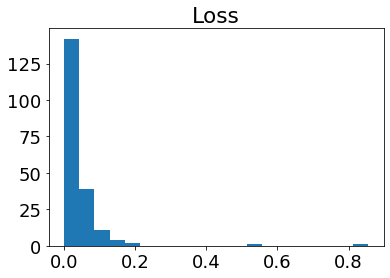

In [7]:
r = 0
f = 0
list_output_data = []
runtime = []
final_loss = []
iteration = []
runs = sorted(glob.glob(rundir+'*'))
for run in runs:
    if os.path.exists(run+'/output_data.pkl'):
        f += 1
        with open(run+'/run.log') as file:
            lines = file.readlines()
            c = 0
            for l, line in enumerate(reversed(lines)):
                if line.strip() == '':
                    continue
                elif 'loss:' in line:
                    final_loss.append(float(line.split()[-1].replace('s','')))
                    c+=1
                elif 'Iterations:' in line:
                    iteration.append(int(line.split()[-1].replace('s','')))    
                    c+=1
                elif 'Runtime:' in line:
                    runtime.append(int(line.split()[-1].replace('s','')))
                    c+=1
                elif l>10:    
                    break
            if c<3:
                print(run+'/run.log ERROR!')
                break
        list_output_data.append(joblib.load(run+'/output_data.pkl'))                     
        print('{:30s}'.format(run+':')+
              '{:15s}'.format('runtime='+str(runtime[-1]))+
              '{:15s}'.format('iterations='+str(iteration[-1]))+
              '{:10s}'.format('loss='+str(final_loss[-1])))            
    else:
        r += 1
        print(run+'/output_data.pkl not found!')
list_output_data = np.array(list_output_data)    
print('\nFinished: ', f)
print('Running: ', r)

# Plot forward and backward march   
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(final_loss, bins=20)
ax.set_title('Loss')

In [8]:
updated_output_data = list_output_data[np.array(final_loss) < 0.02]
print(list_output_data.shape, '->', updated_output_data.shape)

(200, 6) -> (104, 6)


# Plot data

In [9]:
def plot_data(X_predict, nx, ny, obs_times=[], X_obs=[], grid_points=[], R0s_obs=[], R0_ax='', X_ax='', label='', color='b'):
    X_generated = scaler.inverse_transform(X_predict)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(len(X_predict), len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    
    # Plot R
    xp = len(R0_generated)
    if R0_ax:
        R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), R0_generated[:,0], 'b', label='Home '+label)
        R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), R0_generated[:,1], 'r', label='Mobile '+label)
        if len(R0s_obs):
            R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), [R0s_obs[0]]*len(R0_generated), 'bo', markevery=2, fillstyle='none', markersize = 10, label='Home truth')
            R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), [R0s_obs[1]]*len(R0_generated), 'ro', markevery=2, fillstyle='none', markersize = 10, label='Mobile truth')    
        if len(label):
        #    R0_ax.legend()
            R0_ax.set_xlabel('Time (days)')
            R0_ax.set_ylabel('Reproduction number')
        #plt.tight_layout()
        #plt.grid()
        #plt.show()

    
    # Plot groups 
    if len(X_ax): 
        for i, group in enumerate(groups):
            X_ax.flatten()[i].plot(np.linspace(0,(xp-1)*8000/86400,xp), X_generated[:,i, nx, ny], color=color, label=label)
            if len(X_obs):
                if [i, nx, ny] in grid_points:
                    X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, X_obs[:, i, nx, ny], 'ro', markevery=1, fillstyle='full', markersize = 12, label='Observed data')
                else:
                    X_ax.flatten()[i].plot([],[])
            X_ax.flatten()[i].set_title(group)
            if len(label):
            #    X_ax.flatten()[i].legend()
                X_ax.flatten()[i].set_xlabel('Time (days)')
                X_ax.flatten()[i].set_ylabel('Number of People')
            #X_ax.flatten()[i].set_xlim(8,12)    
        #plt.tight_layout()
        #plt.grid()
        #plt.show()

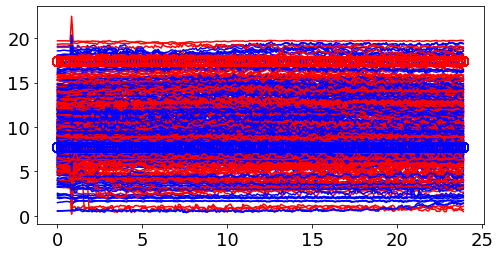

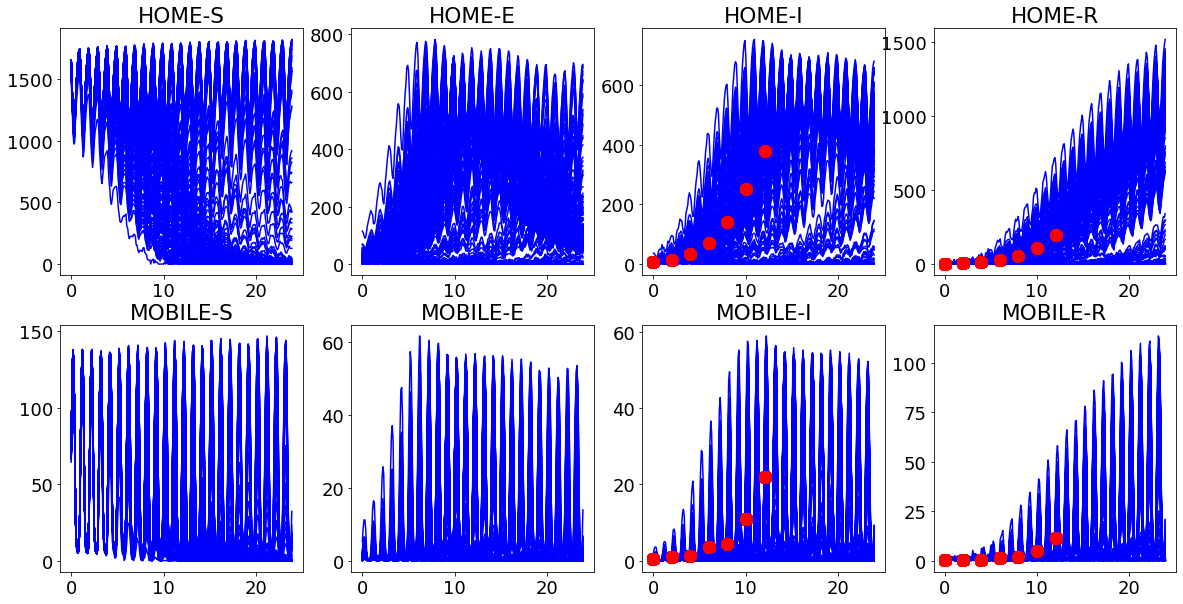

In [10]:
# Plot forward and backward march   
fig, R0_ax = plt.subplots(1,1, figsize=[8,4])
fig, X_ax = plt.subplots(2,4, figsize=[20,10])

for output_data in list_output_data:
    plot_data(output_data[0], 0, 4, obs_times, X_obs[obs_times], grid_points, R0s_obs, R0_ax=R0_ax, X_ax=X_ax, label='')
plt.show()

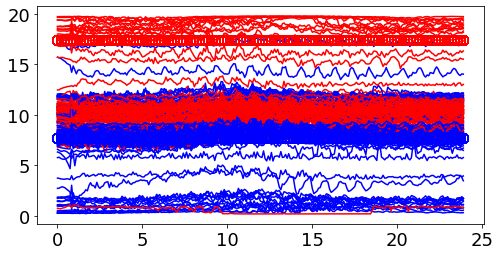

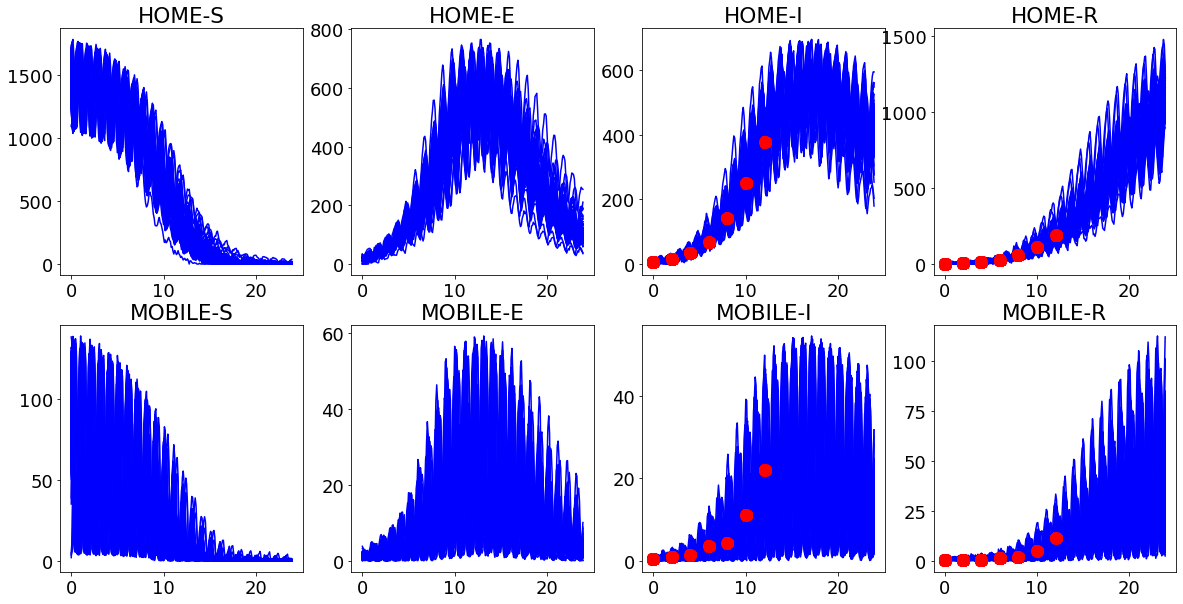

In [11]:
# Plot forward and backward march   
fig, R0_ax = plt.subplots(1,1, figsize=[8,4])
fig, X_ax = plt.subplots(2,4, figsize=[20,10])

for output_data in updated_output_data:
    plot_data(output_data[1], 0, 4, obs_times, X_obs[obs_times], grid_points, R0s_obs, R0_ax=R0_ax, X_ax=X_ax, label='')
plt.show()

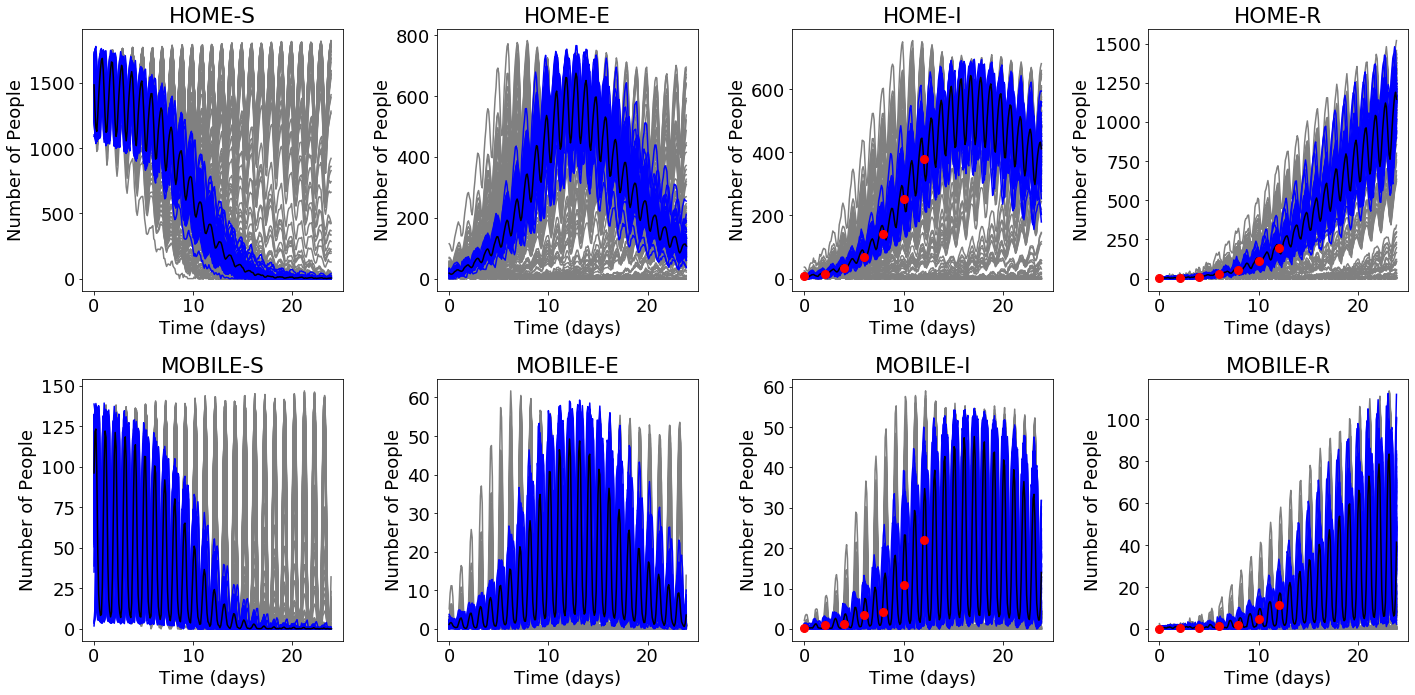

In [12]:
# Plot forward and backward march   
fig, X_ax = plt.subplots(2,4, figsize=[20,10])

for output_data in list_output_data:
    plot_data(output_data[0], 0, 4, obs_times=[], X_obs=[], grid_points=[], R0s_obs=[], R0_ax='', X_ax=X_ax, label='',color='gray')

for output_data in updated_output_data:
    plot_data(output_data[1], 0, 4, obs_times=[], X_obs=[], grid_points=[], R0s_obs=[], R0_ax='', X_ax=X_ax, label='', color='b')
    
X_mean = np.zeros((259, 8, 10, 10))
for output_data in updated_output_data:
    
    X_generated = scaler.inverse_transform(output_data[1])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    X_mean += X_generated
X_mean /= len(updated_output_data)  
     
# Plot groups 
if len(X_ax): 
    for i, group in enumerate(groups):
        X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), X_mean[:,i, 0, 4], 'k-', label='label', zorder=3)
        if len(X_obs):
            if [i, 0, 4] in grid_points:
                X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, X_obs[obs_times][:, i, 0, 4], 'ro', markevery=1, fillstyle='full', markersize = 8, label='Observed data',zorder=3)
            else:
                X_ax.flatten()[i].plot([],[])
        X_ax.flatten()[i].set_title(group)
        #    X_ax.flatten()[i].legend()
        X_ax.flatten()[i].set_xlabel('Time (days)')
        X_ax.flatten()[i].set_ylabel('Number of People')
        #X_ax.flatten()[i].set_xlim(8,12)    
    #plt.tight_layout()
    #plt.grid()
    #plt.show()

plt.tight_layout()
plt.show()    

In [13]:
# Show the iterations where there are observed data
obs_times

[0, 22, 43, 65, 86, 108, 130]

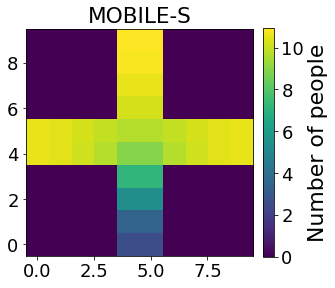

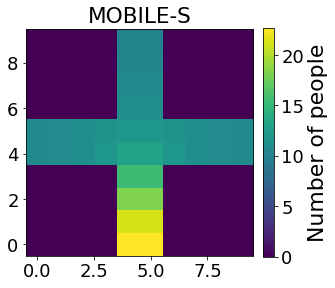

In [14]:
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, ax = plt.subplots(1,1, figsize=[5,5])
#for i, group in enumerate(groups):
im = ax.imshow(X_mean[135,4,:,:], origin='lower')
clb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
clb.set_label(label='Number of people', size=22)
ax.set_title(groups[4])
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=[5,5])
#for i, group in enumerate(groups):
im = ax.imshow(X_mean[130,4,:,:], origin='lower', vmin=0)
clb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
clb.set_label(label='Number of people', size=22)
ax.set_title(groups[4])
plt.tight_layout()

In [15]:
time = 130
R0_hist_prior = []
for output_data in list_output_data[:,0]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    R0_hist_prior.append(R0_generated[time,:])
R0_hist_prior = np.array(R0_hist_prior)

R0_hist_post = []
for output_data in updated_output_data[:,1]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    R0_hist_post.append(R0_generated[time,:])
R0_hist_post = np.array(R0_hist_post)

<function matplotlib.pyplot.show(*args, **kw)>

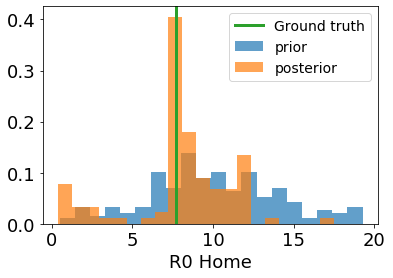

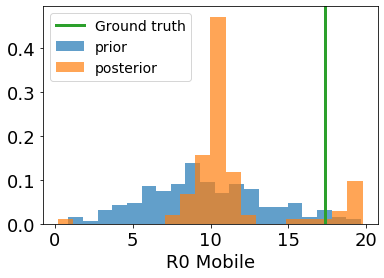

In [16]:
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

#fig, R0_ax0 = plt.subplots(1,2, figsize=[12,4])
fig, R0_ax0 = plt.subplots(1,1, figsize=[6,4])
fig, R0_ax1 = plt.subplots(1,1, figsize=[6,4])
R0_ax = [R0_ax0, R0_ax1]

# Plot R0 histograms
#xrange = (min(R0_hist.min(),R0s_obs[0],R0s_obs[1]),max(R0_hist.max(),R0s_obs[0],R0s_obs[1])) 
R0_ax[0].hist(R0_hist_prior[:,0], bins=20, density=True, label='prior', alpha=0.7)#, range=xrange)
R0_ax[0].hist(R0_hist_post[:,0], bins=20, density=True, label='posterior', alpha=0.7)#, range=xrange)
R0_ax[0].set_xlabel('R0 Home')
R0_ax[1].hist(R0_hist_prior[:,1], bins=20, density=True, label='prior', alpha=0.7)#, range=xrange)
R0_ax[1].hist(R0_hist_post[:,1], bins=20, density=True, label='posterior', alpha=0.7)#, range=xrange)
R0_ax[1].set_xlabel('R0 Mobile')

yrange = R0_ax[0].get_ybound()
R0_ax[0].plot([R0s_obs[0]]*2,yrange, linewidth=3, label='Ground truth')
R0_ax[0].set_ylim(yrange)
yrange = R0_ax[1].get_ybound()
R0_ax[1].plot([R0s_obs[1]]*2,yrange, linewidth=3, label='Ground truth')
R0_ax[1].set_ylim(yrange)     

R0_ax[0].legend()
#plt.tight_layout()
plt.show
R0_ax[1].legend()
#plt.tight_layout()
plt.show

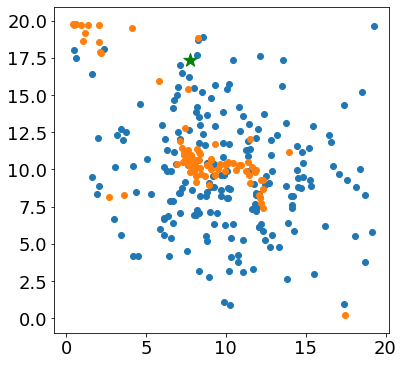

In [17]:
fig, R0_ax = plt.subplots(1,1, figsize=[6,6])

R0_ax.scatter(R0_hist_prior[:,0],R0_hist_prior[:,1])
R0_ax.scatter(R0_hist_post[:,0],R0_hist_post[:,1])
R0_ax.scatter(R0s_obs[0],R0s_obs[1], s=200, marker='*', c='green')

In [18]:
R0e_hist_prior = []
R0e_hist_post = []

for output_data in list_output_data[:,0]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    
    aux_prior = 0
    for time in range(130,131):#range(n_ts)
        s = X_generated[time,0,:,:].sum()/(X_generated[time,0,:,:].sum()+X_generated[time,4,:,:].sum())
        aux_prior += R0_generated[time,0]*s+R0_generated[time,1]*(1-s)
        #R0e_hist_prior.append(R0_generated[time,0]*s+R0_generated[time,1]*(1-s))  
    R0e_hist_prior.append(aux_prior)#/n_ts)
        
for output_data in updated_output_data[:,1]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    
    aux_post = 0
    for time in range(130,131):#range(n_ts)
        s = X_generated[time,0,:,:].sum()/(X_generated[time,0,:,:].sum()+X_generated[time,4,:,:].sum())
        aux_post += R0_generated[time,0]*s+R0_generated[time,1]*(1-s)
        #R0e_hist_post.append(R0_generated[time,0]*s+R0_generated[time,1]*(1-s))  
    R0e_hist_post.append(aux_post)#/n_ts)
    
R0e_hist_prior = np.array(R0e_hist_prior)
R0e_hist_post = np.array(R0e_hist_post)

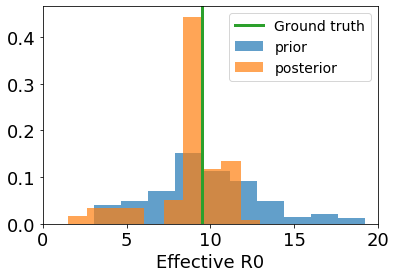

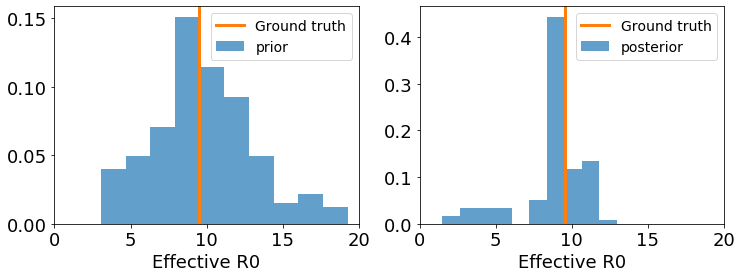

In [19]:
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, R0_ax = plt.subplots(1,1, figsize=[6,4])

# Plot R0 histograms
R0_ax.hist(R0e_hist_prior, density=True, label='prior', alpha=0.7)#, bins=20)
R0_ax.hist(R0e_hist_post, density=True, label='posterior', alpha=0.7)#, bins=20)
R0_ax.set_xlabel('Effective R0')

yrange = (R0_ax.get_ybound())
aux_obs = 0
for time in range(130,131):#range(n_ts)
    s_obs = X_obs[time,0,:,:].sum()/(X_obs[time,0,:,:].sum()+X_obs[time,4,:,:].sum())
    aux_obs += R0s_obs[0]*s_obs+R0s_obs[1]*(1-s_obs)
R0e_obs = aux_obs#/n_ts

R0_ax.plot([R0e_obs]*2,yrange, linewidth=3, label='Ground truth')
R0_ax.set_ylim(yrange)    

R0_ax.set_xlim(0,20) 
R0_ax.legend()
#plt.tight_layout()
plt.show()

fig, R0_ax = plt.subplots(1,2, figsize=[12,4])

# Plot R0 histograms
R0_ax[0].hist(R0e_hist_prior, density=True, label='prior', alpha=0.7)
R0_ax[0].set_xlabel('Effective R0')
yrange = (R0_ax[0].get_ybound())
s_obs = X_obs[time,0,:,:].sum()/(X_obs[time,0,:,:].sum()+X_obs[time,4,:,:].sum())
R0_ax[0].plot([R0s_obs[0]*s_obs+R0s_obs[1]*(1-s_obs)]*2,yrange, linewidth=3, label='Ground truth')
R0_ax[0].set_ylim(yrange)  
R0_ax[0].set_xlim(0,20) 
R0_ax[0].legend()

R0_ax[1].hist(R0e_hist_post, density=True, label='posterior', alpha=0.7)
R0_ax[1].set_xlabel('Effective R0')
yrange = (R0_ax[1].get_ybound())
s_obs = X_obs[time,0,:,:].sum()/(X_obs[time,0,:,:].sum()+X_obs[time,4,:,:].sum())
R0_ax[1].plot([R0s_obs[0]*s_obs+R0s_obs[1]*(1-s_obs)]*2,yrange, linewidth=3, label='Ground truth')
R0_ax[1].set_ylim(yrange)  
R0_ax[1].set_xlim(0,20) 
R0_ax[1].legend()
  

#plt.tight_layout()
plt.show()


In [20]:
time = 130
X_hist_prior = []
for output_data in list_output_data[:,0]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    X_hist_prior.append(X_generated[time,:, 0, 4].reshape(len(groups),-1).sum(axis=1))  
X_hist_prior = np.array(X_hist_prior)

X_hist_post = []
for output_data in updated_output_data[:,1]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    X_hist_post.append(X_generated[time,:, 0, 4].reshape(len(groups),-1).sum(axis=1))  
X_hist_post = np.array(X_hist_post)

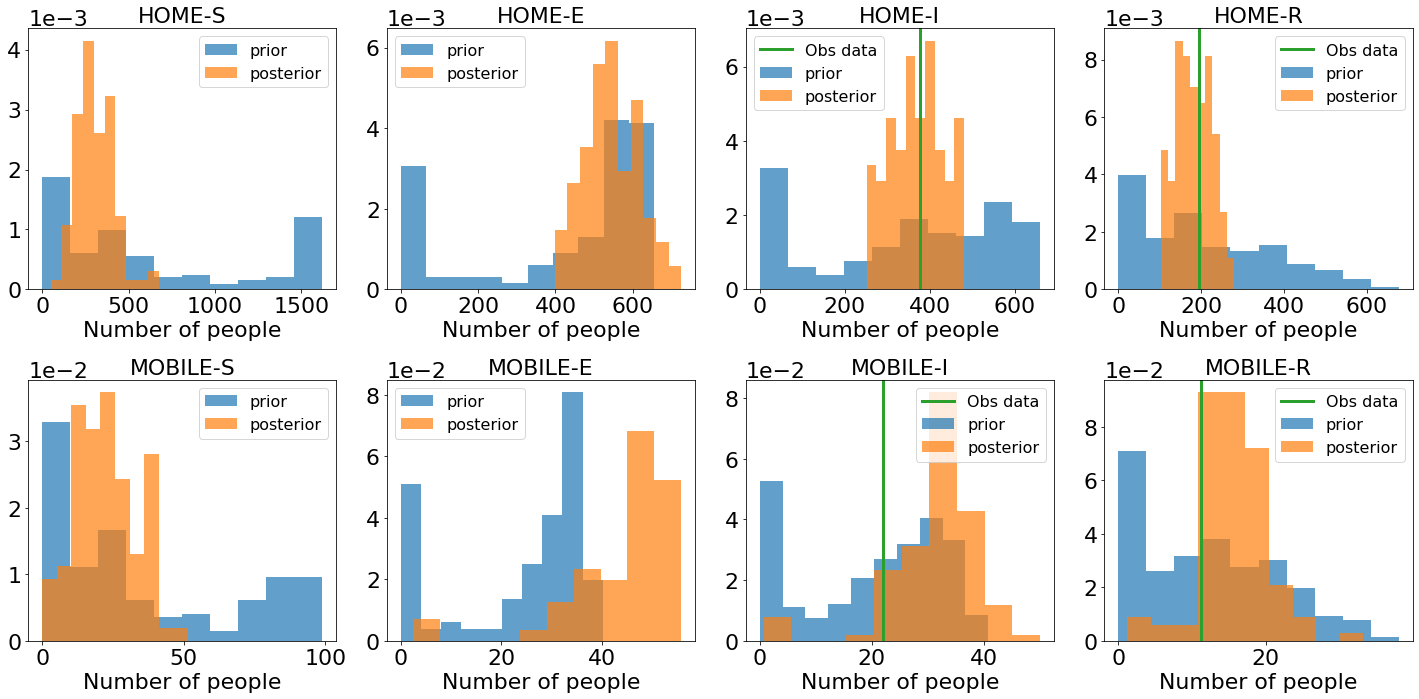

In [21]:
# Plot forward and backward march   
mpl.rcParams.update({'font.size': 16})
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 
mpl.rc('axes', labelsize=22)
mpl.rc('axes', titlesize=22)

fig, X_ax = plt.subplots(2,4, figsize=[20,10])
# Plot groups histograms
for i, group in enumerate(groups):
        #xrange = (X_hist[:,:4].min(),X_hist[:,:4].max()) if brange else None
        X_ax.flatten()[i].hist(X_hist_prior[:,i], density=True, label='prior',alpha=0.7)
        X_ax.flatten()[i].hist(X_hist_post[:,i], density=True, label='posterior',alpha=0.7)
        X_ax.flatten()[i].set_xlabel('Number of people')
        X_ax.flatten()[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        if i in np.array(grid_points)[:,0] and time in obs_times:
            yrange = X_ax.flatten()[i].get_ybound()
            X_ax.flatten()[i].plot([X_obs[time, i, 0, 4].sum()]*2,yrange, linewidth=3, label='Obs data')
            X_ax.flatten()[i].set_ylim(yrange)      
        X_ax.flatten()[i].set_title(group)
        X_ax.flatten()[i].legend()     
plt.tight_layout()

## Compare the whole population with the ground truth

In [22]:
compartments = ['Susceptible','Exposed','Infecitous','Recovered']

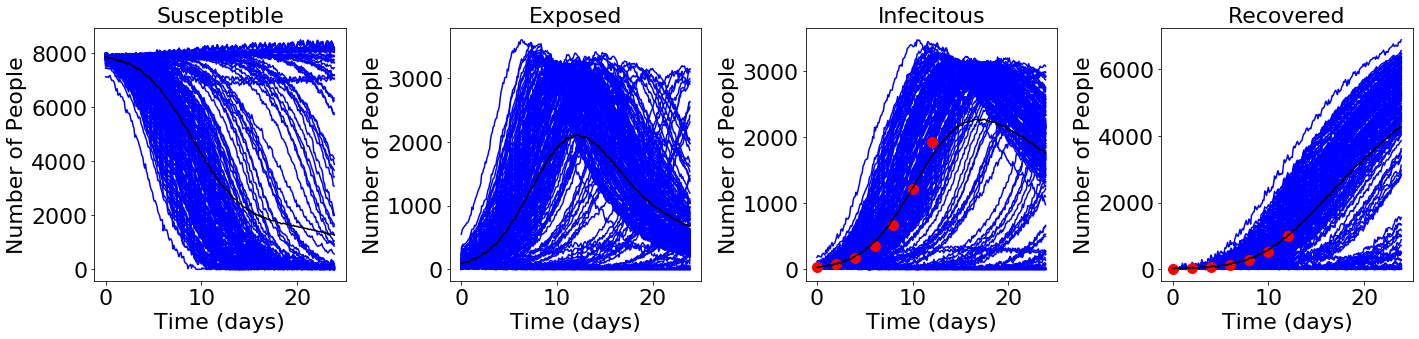

In [23]:
fig, X_ax = plt.subplots(1,4, figsize=[20,5])

for output_data in list_output_data:
    
    X_generated = scaler.inverse_transform(output_data[0])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    
    # Plot groups 
    if len(X_ax): 
        for i, group in enumerate(compartments):
            X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                                   X_generated[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                                   'b-', 
                                   label='Priors')
                    
        
for i, group in enumerate(compartments):
    if i in np.array(grid_points)[:,0]:
        X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, 
                              X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1), 
                              'ro', markevery=1, 
                              fillstyle='full', 
                              markersize = 10, 
                              label='Ground truth')
#         X_ax.flatten()[i].errorbar(np.array(obs_times)*8000/86400, 
#                                    X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    yerr=3*0.05*X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    fmt='or',
#                                    markersize = 8, 
#                                    elinewidth=4,
#                                    #capsize = 10,
#                                    #barsabove=True,
#                                    zorder=3)
        
    X_ax.flatten()[i].set_title(group)
    #X_ax.flatten()[i].legend()
    X_ax.flatten()[i].set_xlabel('Time (days)')
    X_ax.flatten()[i].set_ylabel('Number of People')
    #X_ax.flatten()[0].set_ylim(top=8000)
    
X_mean = np.zeros((259, 8, 10, 10))
for output_data in list_output_data:
    
    X_generated = scaler.inverse_transform(output_data[0])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    X_mean += X_generated
X_mean /= len(list_output_data)  

# Plot groups 
if len(X_ax): 
    for i, group in enumerate(compartments):
        X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                               X_mean[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                               'k-', 
                               label='Priors')
        

plt.tight_layout()
plt.show()
    

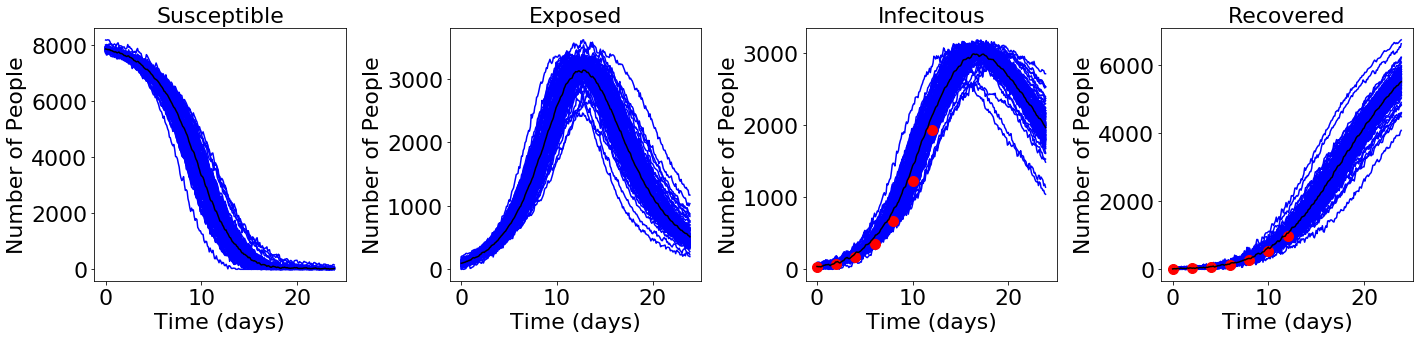

In [24]:
fig, X_ax = plt.subplots(1,4, figsize=[20,5])

for output_data in updated_output_data:
    
    X_generated = scaler.inverse_transform(output_data[1])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    
    # Plot groups 
    if len(X_ax): 
        for i, group in enumerate(compartments):
            X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                                   X_generated[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                                   'b-', 
                                   label='Priors')
                    

for i, group in enumerate(compartments):
    if i in np.array(grid_points)[:,0]:
        X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, 
                              X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1), 
                              'ro', markevery=1, 
                              fillstyle='full', 
                              markersize = 10, 
                              label='Ground truth')
#         X_ax.flatten()[i].errorbar(np.array(obs_times)*8000/86400, 
#                                    X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    yerr=3*0.05*X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    fmt='or',
#                                    markersize = 6, 
#                                    elinewidth=3,
#                                    #capsize = 10,
#                                    #barsabove=True,
#                                    zorder=3)

        
    X_ax.flatten()[i].set_title(group)
    #X_ax.flatten()[i].legend()
    X_ax.flatten()[i].set_xlabel('Time (days)')
    X_ax.flatten()[i].set_ylabel('Number of People')
    #X_ax.flatten()[0].set_ylim(top=8000)
    
X_mean = np.zeros((259, 8, 10, 10))
for output_data in updated_output_data:
    
    X_generated = scaler.inverse_transform(output_data[1])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    X_mean += X_generated
X_mean /= len(updated_output_data)  

# Plot groups 
if len(X_ax): 
    for i, group in enumerate(compartments):
        X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                               X_mean[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                               'k-',  
                               label='Posterior')

plt.tight_layout()
plt.show()
    

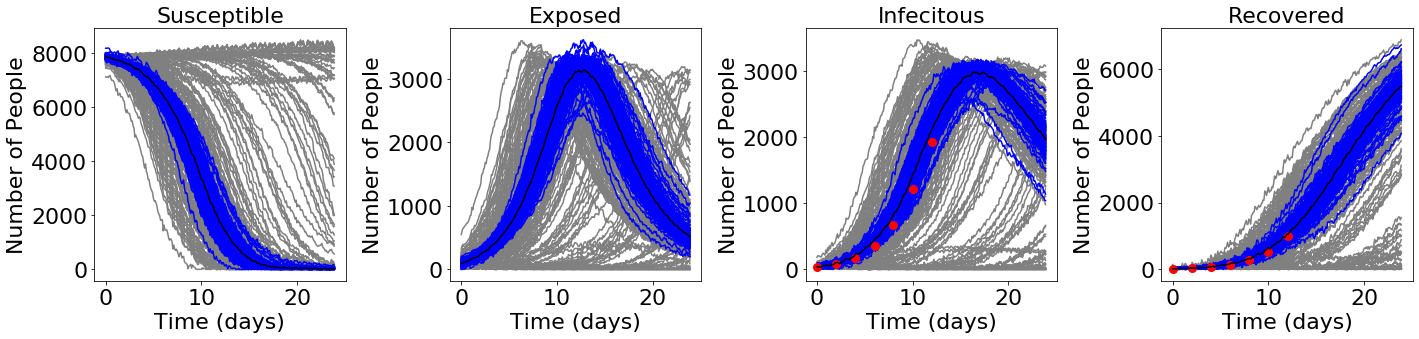

In [25]:
fig, X_ax = plt.subplots(1,4, figsize=[20,5])

for output_data in list_output_data:
    
    X_generated = scaler.inverse_transform(output_data[0])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    
    # Plot groups 
    if len(X_ax): 
        for i, group in enumerate(compartments):
            X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                                   X_generated[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                                   '-',
                                   color='grey',
                                   label='Priors')
                    
                
for output_data in updated_output_data:
    
    X_generated = scaler.inverse_transform(output_data[1])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    
    # Plot groups 
    if len(X_ax): 
        for i, group in enumerate(compartments):
            X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                                   X_generated[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                                   'b-', 
                                   label='Priors')                
        
for i, group in enumerate(compartments):
    if i in np.array(grid_points)[:,0]:
        X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, 
                              X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1), 
                              'ro', markevery=1, 
                              fillstyle='full', 
                              markersize = 8, 
                              label='Ground truth')
#         X_ax.flatten()[i].errorbar(np.array(obs_times)*8000/86400, 
#                                    X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    yerr=3*0.05*X_obs[obs_times][:, [i,i+4], :, :].reshape(len(obs_times),-1).sum(axis=1),
#                                    fmt='or',
#                                    markersize = 6, 
#                                    elinewidth=3,
#                                    #capsize = 10,
#                                    #barsabove=True,
#                                    zorder=3)
        
    X_ax.flatten()[i].set_title(group)
    #X_ax.flatten()[i].legend()
    X_ax.flatten()[i].set_xlabel('Time (days)')
    X_ax.flatten()[i].set_ylabel('Number of People')
    #X_ax.flatten()[0].set_ylim(top=8000)
    
X_mean = np.zeros((259, 8, 10, 10))
for output_data in updated_output_data:
    
    X_generated = scaler.inverse_transform(output_data[1])
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 
    n_ts = len(X_generated)
    X_mean += X_generated
X_mean /= len(updated_output_data)  

# Plot groups 
if len(X_ax): 
    for i, group in enumerate(compartments):
        X_ax.flatten()[i].plot(np.linspace(0,(n_ts-1)*8000/86400,n_ts), 
                               X_mean[:,[i,i+4], :, :].reshape(len(X_generated),-1).sum(axis=1), 
                               'k-',  
                               label='Posterior')    

plt.tight_layout()
plt.show()

In [26]:
time = 130
X_hist_prior = []
for output_data in list_output_data[:,0]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    X_hist_prior.append(X_generated[time,:, :, :].reshape(len(groups),-1).sum(axis=1))  
X_hist_prior = np.array(X_hist_prior)

X_hist_post = []
for output_data in updated_output_data[:,1]: 
    X_generated = scaler.inverse_transform(output_data)
    R0_generated = X_generated[:,pca_size:]
    X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
    X_generated = X_generated.reshape(-1, len(groups), nl, nc)
    X_generated[X_generated<0] = 0 

    X_hist_post.append(X_generated[time,:, :, :].reshape(len(groups),-1).sum(axis=1))  
X_hist_post = np.array(X_hist_post)

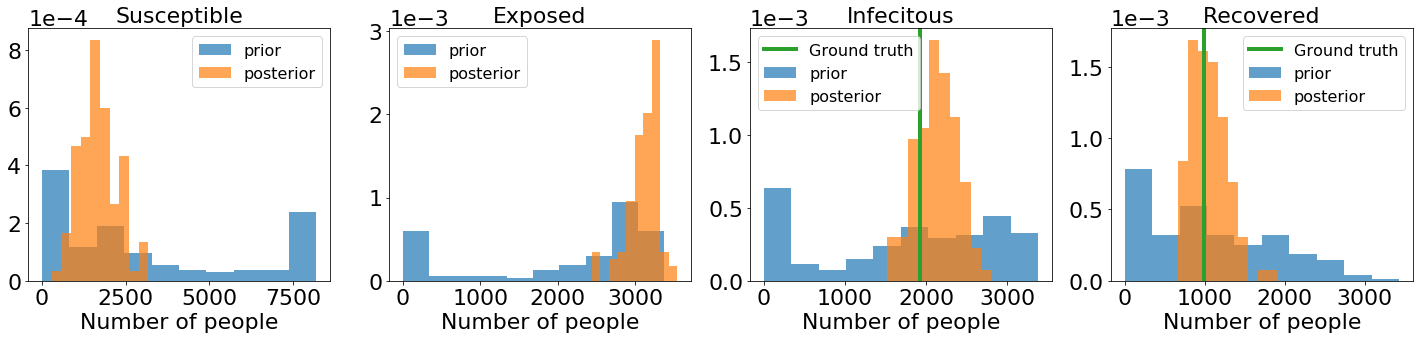

In [27]:
mpl.rcParams.update({'font.size': 16})
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 
mpl.rc('axes', labelsize=22)
mpl.rc('axes', titlesize=22)

fig, X_ax = plt.subplots(1,4, figsize=[20,5])
# Plot groups histograms
for i, group in enumerate(compartments):
        #xrange = (X_hist[:,:4].min(),X_hist[:,:4].max()) if brange else None
        X_ax.flatten()[i].hist(X_hist_prior[:,[i,i+4]].sum(axis=1), density=True, label='prior',alpha=0.7)
        X_ax.flatten()[i].hist(X_hist_post[:,[i,i+4]].sum(axis=1), density=True, label='posterior',alpha=0.7)
        X_ax.flatten()[i].set_xlabel('Number of people')
        X_ax.flatten()[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        if i in np.array(grid_points)[:,0] and time in obs_times:
            yrange = X_ax.flatten()[i].get_ybound()
            X_ax.flatten()[i].plot([X_obs[time, [i,i+4], :, :].sum()]*2,yrange, linewidth=4, label='Ground truth')
            X_ax.flatten()[i].set_ylim(yrange)      
        X_ax.flatten()[i].set_title(group)
        X_ax.flatten()[i].legend()     
plt.tight_layout()